In [17]:
%matplotlib inline
import os
import glob 
import numpy as np
import xarray as xr
import pandas as pd
import datetime
import scipy.stats as stats
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import seaborn as sns
import shapefile   
import geopandas as gpd
import geoplot as gplt
import contextily as cx
#from datetime import datetime
from fitter import Fitter, get_common_distributions, get_distributions
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [18]:
# Directories and Variable initialization
dir_era5 = '/glade/work/mingge/ERA5/'
dir_era5 = '/glade/campaign/collections/rda/data/ds633.0/e5.oper.an.pl/'
dir_o = '/glade/campaign/mmm/c3we/mingge/COEXIST/ERA5/'
dir_z = '/glade/campaign/mmm/c3we/mingge/COEXIST/ERA5/Z500_ERA5_US_mask/'

year_s = 1979
year_e = 2020

In [19]:
# ERA5 U.S. mask I'm going to use to mask large domain for speed up
flnm_mask = '/glade/campaign/mmm/c3we/COEXIST/ERA5_events/masks/NLDAS_ERA5_US_mask_regrid.nc'
with  xr.open_dataset(flnm_mask) as ds_mask:
    print(flnm_mask)
    US_mask = ds_mask.US_mask
    
lat_s = min(ds_mask.lat.values)
lat_e = max(ds_mask.lat.values)

lon_s = min(ds_mask.lon.values)
lon_e = max(ds_mask.lon.values)
print(US_mask.shape, lat_s, lat_e, lon_s, lon_e)

/glade/campaign/mmm/c3we/COEXIST/ERA5_events/masks/NLDAS_ERA5_US_mask_regrid.nc
(110, 230) 25.5 52.75 235.25 292.5


In [20]:
# Calculate daily average Z500 over U.S. mask domain
# this only needs once to speed things up
# I use job array 
is_crop = False
if  is_crop == True:
    year_s = 1979
    year_e = 2019
    for year in range(year_s, year_e+1, 1):
        is_first = True
        flnm_z = dir_z + 'z500_' + str(year) + '.nc'
        print(flnm_z)
        dStartDay =datetime(year, 1, 1,12)
        dStopDay = datetime(year, 12, 31,12)
        rgdTimeDD = pd.date_range(dStartDay, end=dStopDay, freq='d').strftime('%Y%m%d')
        yyyymmdd_int = [int(i) for i in rgdTimeDD]

        if os.path.isfile(flnm_z):
            print(flnm_z, 'exist')
            with  xr.open_dataset(flnm_z) as ds_z:
                data_4d[year-year_s] = ds_z.Z
        else:    
            for month in range(1,13):
                yyyymm_s = str(year*100 + month)
                print(yyyymm_s)
                # glob order is arbitrary, sort them 
                for flnm in sorted(glob.glob(dir_era5 + yyyymm_s + "/e5.oper.an.pl.128_129_z.ll025sc.*.nc")):
                    print(flnm)
                    with  xr.open_dataset(flnm) as ds:
                        # select z500hPa, crop to target domain, and daily mean
                        # Follow original ERA from North to South !
                        z500_2d = ds.Z.sel(level=500).sel(latitude=slice(lat_e, lat_s),longitude=slice(lon_s, lon_e)).mean(dim='time') 
    
                        # concatenate daily data 
                        if is_first:
                            z500_3d = z500_2d
                            is_first = False
                        else:
                            z500_3d = xr.concat([z500_3d, z500_2d], dim="time") 
                            
            print(flnm_z)
            #z500_3d.to_netcdf(path = flnm_z)  
            z500_xr = xr.DataArray(z500_3d, 
                    coords={'latitude': ds['latitude'].sel(latitude=slice(lat_e, lat_s)), 
                            'longitude': ds['longitude'].sel(longitude=slice(lon_s, lon_e)),
                            'time':yyyymmdd_int},
                    dims = ['time','latitude', 'longitude'],
                    attrs = {'script':'Ming Ge: coexist_paper_2.ipynb'})
        z500_xr = z500_xr.rename('z500_us') 
        z500_xr.to_netcdf( path = flnm_z)

#### Calculate domain average daily Z500 and it's abs(anomaly) 

In [21]:
%%time
 
n_year = year_e - year_s
z500_1d = np.empty(shape=[0])
    
for year in range(year_s, year_e+1, 1):
    flnm_z = dir_z + 'z500_' + str(year) + '.nc'
    #print(flnm_z)
    with  xr.open_dataset(flnm_z) as ds_z:
        z500_avg = ds_z.z500_us.mean(dim = ['latitude', 'longitude']).values
     
    z500_1d = np.append(z500_1d,z500_avg)

z500_cli = np.mean(z500_1d)
z500_abs = abs(z500_1d - z500_cli )

n_day = len(z500_1d) 

print('there are ', n_day, ' days') # 365x41 + 11-leapyear
print('z500 daily average = ', z500_cli)

there are  15341  days
z500 daily average =  55808.17410223217
CPU times: user 1.12 s, sys: 927 ms, total: 2.04 s
Wall time: 12.1 s


In [22]:
#### 14-day rate vs 14day height absolute anomaly 

In [23]:
StartDay = datetime.datetime(1979, 1, 1,  0)
StopDay  = datetime.datetime(2020, 12, 31, 23)

TimeDD = pd.date_range(StartDay, end=StopDay, freq='d')

In [24]:
# read Obj file and group it according to HUC
dir_obj_txt = '/glade/campaign/mmm/c3we/COEXIST/ERA5_events/ERA5_events/'
flnm_obj_txt = dir_obj_txt + 'ERA5_accumulated_daily_pr_p99_2d_events_1979-2020_US.txt'
print(flnm_obj_txt)

df = pd.read_csv(flnm_obj_txt, sep=" ")  
df['date'] = pd.to_datetime(df['date'], format='%Y%m%d')
 
# Split Data into 'HUC2' Groups by .groupby() function. 
# This returns a GroupBy object which is a dictionary
# Then use different methods on this object 
huc2_g = df.groupby(['HUC2']) 

# number of unique groups
# the same as df.HUC2.nunique() 
n_huc2 = huc2_g.ngroups 
print('there are: ', n_huc2, ' groups')

window_size = 14
n_ActDD = n_day - window_size + 1
n_event_2d = np.zeros((n_huc2, n_day), dtype=int)
ns = 0
for name_of_group, contents_of_group in huc2_g: 
    event_date = contents_of_group[['event_id', 'date']]
    print(name_of_group)
    ii = 0
    while ii < n_ActDD:
        window = TimeDD[ii : ii + window_size]
        # select rows between two values: 14-day count here
        event_select = event_date[event_date['date'].between(window[0], window[-1])]
        # count events by unique event_id
        n_event_2d[ns,ii] = len(np.unique(event_select['event_id'].to_numpy()))
        ii = ii + 1
    ns = ns + 1

/glade/campaign/mmm/c3we/COEXIST/ERA5_events/ERA5_events/ERA5_accumulated_daily_pr_p99_2d_events_1979-2020_US.txt
there are:  18  groups
('Arkansas',)
('CoastalBasinsNP',)
('Colorado',)
('Columbia',)
('GreatBasin',)
('GreatLakes',)
('LowerMississippi',)
('LowerMissouri',)
('NorthAtlantic',)
('Ohio',)
('RedAndOuachita',)
('RedRiver',)
('RioGrande',)
('SacramentoAndKlamath',)
('Southeast',)
('Texas',)
('UpperMississippi',)
('UpperMissouri',)


In [25]:
%%time
# this is for consistency with previous work (shapefile order)
# It is different from the order of object txt file
# reorder obj txt file 'huc2' according to US river basins shapefile
name_obj = (list(huc2_g.groups.keys()))
name_obj = [sub.lower() for sub in name_obj]

flnm_shp = '/glade/campaign/mmm/c3we/COEXIST/ERA5_events/US_river_basins/US_river_basins.shp'
shp_gpd = gpd.read_file(flnm_shp)

# reorder count according to shapefile order
# series to list
name_shp = shp_gpd.names.tolist() 

# Replace substring in list of strings
name_shp = [sub.replace(' ', '').lower() for sub in name_shp]

n_event_2d_new = np.zeros((n_huc2, n_day), dtype=int)

#reorder obj huc according to shapefile 
for ns in range(n_huc2):
    # get the index of name_shp[ns]
    index = name_obj.index(name_shp[ns])
    n_event_2d_new[ns] = n_event_2d[index]

CPU times: user 625 ms, sys: 32.1 ms, total: 657 ms
Wall time: 978 ms


In [26]:
window_size = 14
 
n_ActDD = n_day - window_size + 1
z500_14day_avg_1d = np.zeros((n_ActDD))

nd = 0
while nd < n_ActDD:
    z500_14day_avg_1d[nd] = z500_abs[nd : nd + window_size].mean()
    nd += 1
     

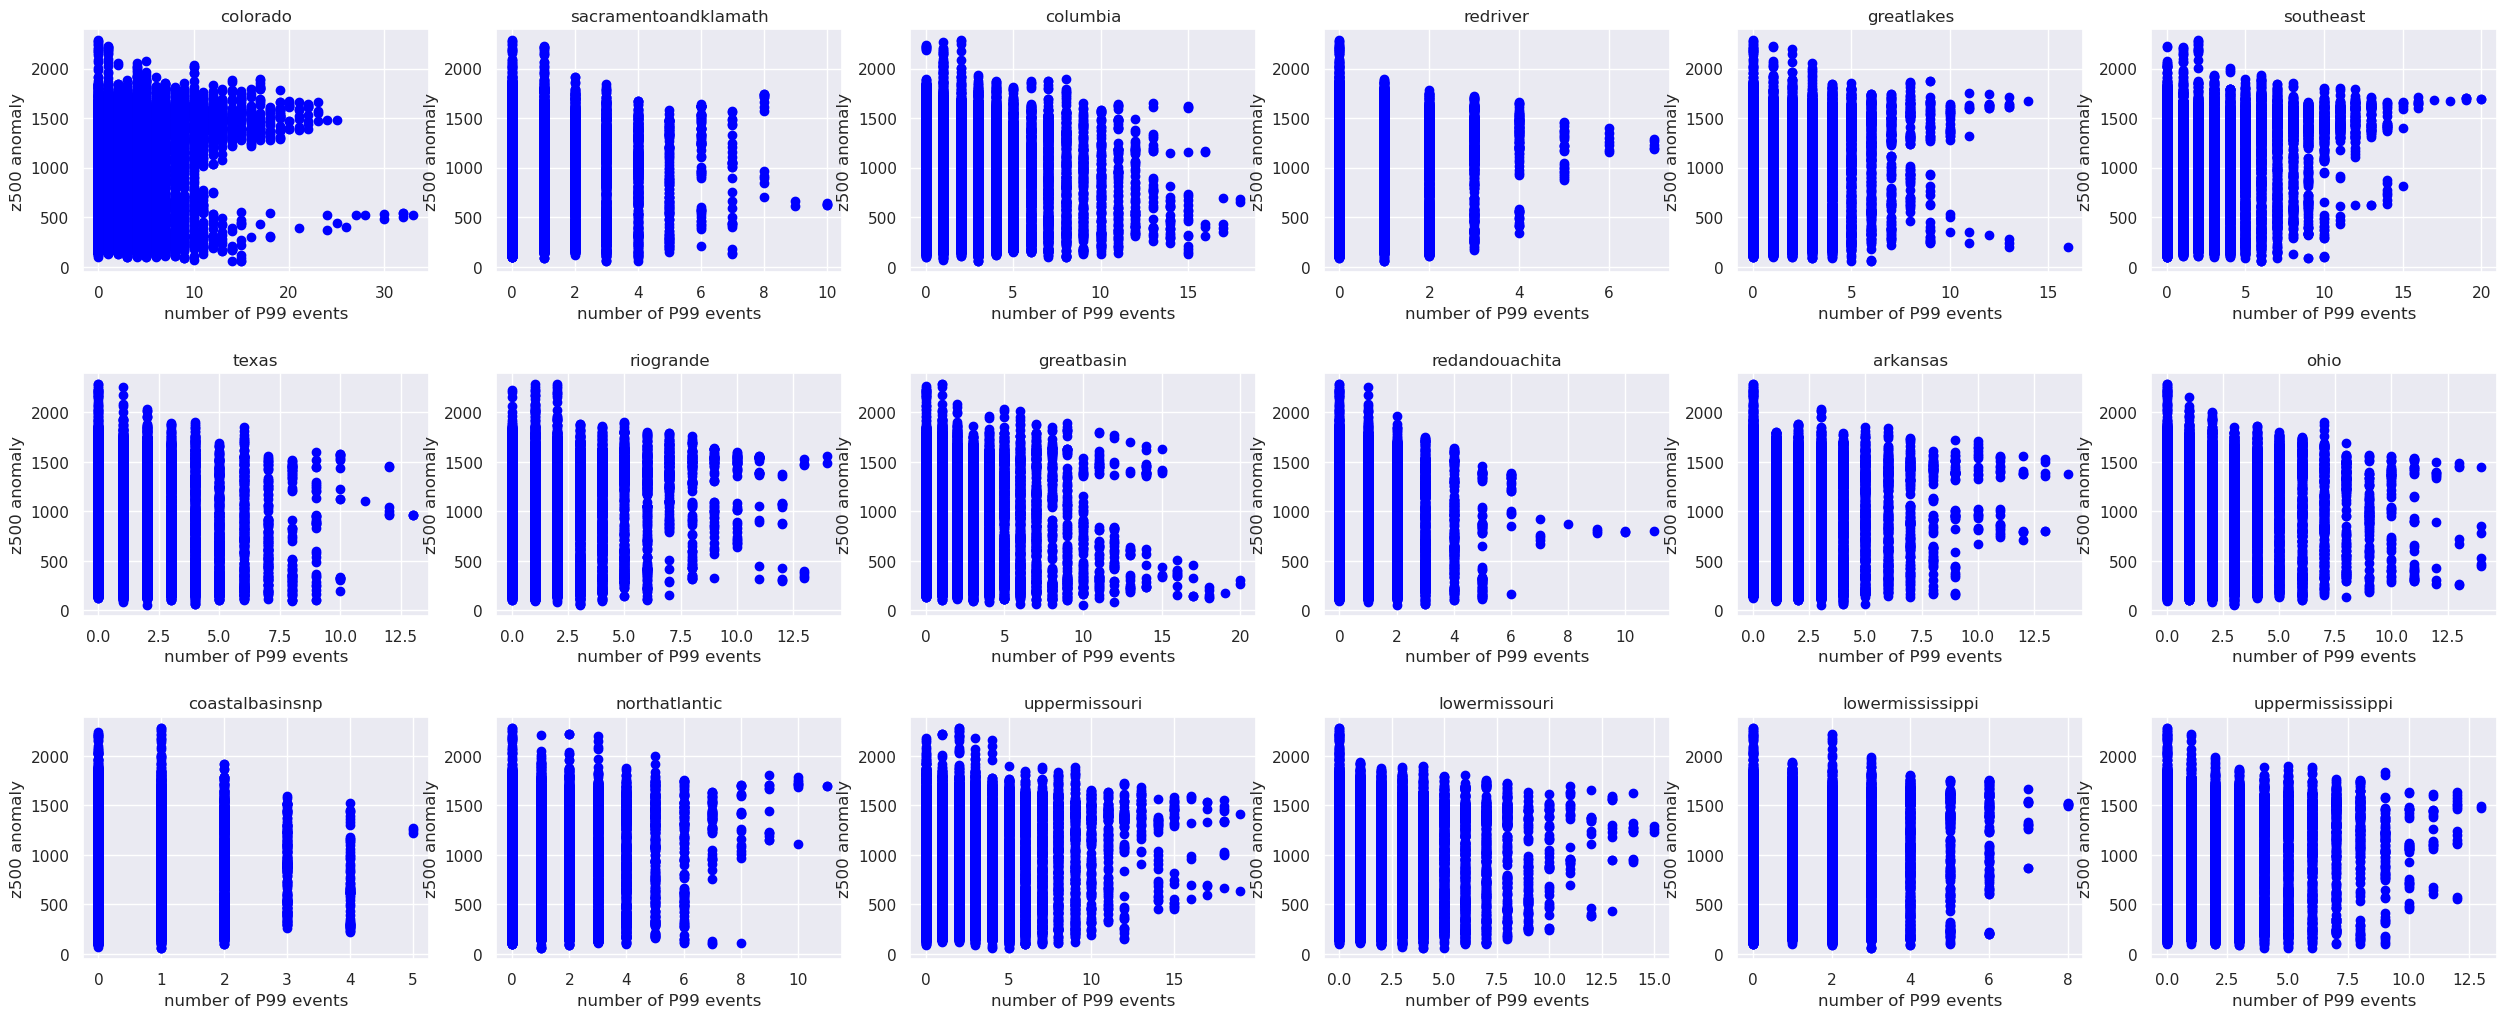

In [27]:
#set seaborn plotting aesthetics as default
sns.set()

n_col = 6
n_row = 3

#define plotting region (3 rows, 6 columns)
fig, axes = plt.subplots(n_row, n_col, figsize=(25, 10))
fig.tight_layout(h_pad=4)
for ns in range(n_huc2):
    nrow = int(ns/n_col)
    ncol = ns - nrow*n_col 
     
    # Create the pandas DataFrame with column name is provided explicitly 
    data = {'z500_anomaly': z500_14day_avg_1d, 'NumberOfEvent' : n_event_2d_new[ns,:-13]}
    df = pd.DataFrame(data) 
    
    # remove FillValue
    #df = df[df.P99_Overlap_Fraction != -99]
    
    axes[nrow,ncol].scatter( df.NumberOfEvent, df.z500_anomaly, c ="blue")
    axes[nrow,ncol].set_ylabel("z500 anomaly")
    axes[nrow,ncol].set_xlabel("number of P99 events")
    axes[nrow,ncol].set_title(name_shp[ns])